# Cell cycle model CCMMV001
**Cell cycle with constant mass model for mammalians ver. 001**

Packages

In [2]:
#using DifferentialEquations
using OrdinaryDiffEq, ParameterizedFunctions, NamedTuples
using PyDSTool, PyCall, PyPlot
using JLD

In [3]:
include("custom_functions.jl");
include("plot_functions.jl");

In [4]:
@load "CCMMV001_data.jld"

6-element Array{Symbol,1}:
 :curve_fold1  
 :curve_fold2  
 :curve_lcycle 
 :curve_lcycle2
 :curve_stst   
 :curve_stst2  

## Model system of ODE's

A model for the cell cycle with constant mass is given by

\begin{align}
\frac{d MPF}{dt}       &= k_{m0}Mass - (k_{m2} + k_{m2a}Wee1)\cdot MPF + (k_{m1} + k_{m1a}Cdc25_{P})\cdot MPF_{P} - (k_{m3} + k_{m3a} APC_{P})MPF, \\ 
\frac{d MPF_{P}}{dt}   & = (k_{m2} + k_{m2b}Wee1)\cdot MPF - (k_{m1} + k_{m1a}Cdc25_{P})\cdot MPF_{P} - (k_{m3}+ k_{m3a} APC_{P})MPF_{P},  \\
\frac{d Wee1}{dt}      &= V_{w1} \frac{Wee1_{T} - Wee1 }{J_{w1} + (Wee1_{T} - Wee1) }  - k_{w2} (MPF + \alpha MPF_{P}) \frac{Wee1}{J_{w2} + Wee1}, \\
\frac{d Cdc25_{P}}{dt} &= k_{c1} (MPF + \alpha MPF_{P}) \frac{Cdc25_{T} - Cdc25_{P}}{J_{c1} + (Cdc25_{T} - Cdc25_{P})}  - V_{c2}\frac{Cdc25_{P}}{J_{c2} + Cdc25_{P}}, \\
\frac{d IE_{A}}{dt}    &= k_{i1} (MPF + \alpha MPF_{P})\frac{IE_{T} - IE_{A}}{J_{i1} + (IE_{T} - IE_{A})} - V_{i2} \frac{IE_{A}}{J_{i2} + IE_{A}}, \\       
\frac{d APC_{P}}{dt}   &= k_{a1}IE_{A} \frac{APC_{T} - APC_{P}}{J_{a1}+(APC_{T} - APC_{P})} - V_{a2}\frac{APC_{P}}{J_{a2}+APC_{P}} .
\end{align}

**Model function**

In [5]:
f = @ode_def_bare CCMMV001 begin
    ## System of ODE (vector field)
    dMPF     = k_m0*Mass - (k_m2 + k_m2a*Wee1)*MPF + (k_m1 + k_m1a*Cdc25_P)*MPF_P - (k_m3 + k_m3a*APC_A)*MPF
    dMPF_P   = (k_m2 + k_m2a*Wee1)*MPF - (k_m1 + k_m1a*Cdc25_P)*MPF_P - (k_m3 + k_m3a*APC_A)*MPF_P
    dWee1    = V_w1*(Wee1_T - Wee1)/(J_w1 + Wee1_T - Wee1) - k_w2*(MPF + MPF_P*alpha)*Wee1/(J_w2 + Wee1)
    dCdc25_P = k_c1*(MPF + MPF_P*alpha)*(Cdc25_T - Cdc25_P)/(J_c1 + Cdc25_T - Cdc25_P) - V_c2*Cdc25_P/(J_c2 + Cdc25_P)
    dIE_A    = k_i1*(MPF + MPF_P*alpha)*(IE_T - IE_A)/(J_i1 + IE_T - IE_A) - V_i2*IE_A/(J_i2 + IE_A)
    dAPC_A   = k_a1*IE_A*(APC_T - APC_A)/(J_a1 + APC_T - APC_A) - V_a2*APC_A/(J_a2 + APC_A)
end k_m0 k_m1 k_m1a k_m2 k_m2a k_m3 k_m3a V_w1 k_w2 J_w1 J_w2 k_c1 V_c2 k_c2a J_c1 J_c2 k_i1 V_i2 J_i1 J_i2 k_a1 V_a2 J_a1 J_a2 alpha Wee1_T Cdc25_T IE_T APC_T Chk2_T theta_M Mass

(::CCMMV001) (generic function with 2 methods)

## Basal value of $V_{c2}=1.4$

In [6]:
params = @NT(k_m0=0.2, k_m1=0.4, k_m1a=20.0, k_m2=0.4, k_m2a=50.0, k_m3=0.2, k_m3a=6.35, 
    V_w1=1.0, k_w2=5.3, J_w1=0.01, J_w2=0.01, k_c1=8.5, V_c2=1.4, k_c2a=2.2, J_c1=0.01, J_c2=0.01, 
    k_i1=1.7, V_i2=0.4, J_i1=0.001, J_i2=0.001, k_a1=6.8, V_a2=1.7, J_a1=0.001, J_a2=0.001, 
    alpha=0.05, Wee1_T=1.0, Cdc25_T=1.0, IE_T=1.0, APC_T=1.0, Chk2_T=1.0, theta_M=0.2, Mass=0.5)

(k_m0 = 0.2, k_m1 = 0.4, k_m1a = 20.0, k_m2 = 0.4, k_m2a = 50.0, k_m3 = 0.2, k_m3a = 6.35, V_w1 = 1.0, k_w2 = 5.3, J_w1 = 0.01, J_w2 = 0.01, k_c1 = 8.5, V_c2 = 1.4, k_c2a = 2.2, J_c1 = 0.01, J_c2 = 0.01, k_i1 = 1.7, V_i2 = 0.4, J_i1 = 0.001, J_i2 = 0.001, k_a1 = 6.8, V_a2 = 1.7, J_a1 = 0.001, J_a2 = 0.001, alpha = 0.05, Wee1_T = 1.0, Cdc25_T = 1.0, IE_T = 1.0, APC_T = 1.0, Chk2_T = 1.0, theta_M = 0.2, Mass = 0.5)

### Some solutions

**G2 stage**. Initial conditions and parameter options.

In [7]:
u0 = [0.006,      # MPF
      0.493,      # MPF_P
      0.998,      # Wee1
      0.002,      # Cdc25_P
      0.000,      # IE_A
      0.000]      # APC_A
tspan = (0.0, 40.0)
dtmax = 0.1
alg = Rosenbrock23()
prob = ODEProblem(f, u0, tspan, params)
sol = solve(prob, alg; (:dtmax, dtmax))
sol.errors

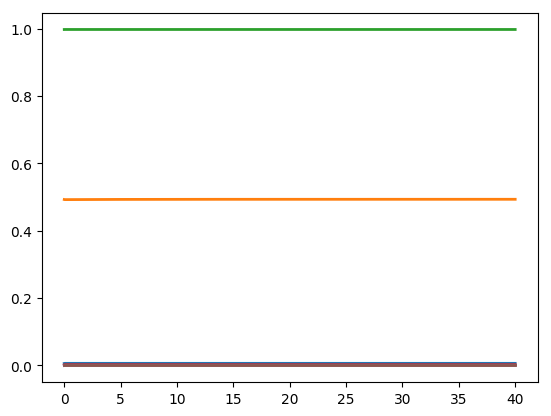

6-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7efe9237d1d0>
 PyObject <matplotlib.lines.Line2D object at 0x7efe9237d3d0>
 PyObject <matplotlib.lines.Line2D object at 0x7efe9237d510>
 PyObject <matplotlib.lines.Line2D object at 0x7efe9237d650>
 PyObject <matplotlib.lines.Line2D object at 0x7efe9237d790>
 PyObject <matplotlib.lines.Line2D object at 0x7efe9237d8d0>

In [8]:
plot(sol.t, sol.u, lw=2)

**M phase**. Changing $Mass$ to 3.0. This moves the dynamics to oscillations.

In [23]:
params = @NT(k_m0=0.2, k_m1=0.4, k_m1a=20.0, k_m2=0.4, k_m2a=50.0, k_m3=0.2, k_m3a=6.35, 
    V_w1=1.0, k_w2=5.3, J_w1=0.01, J_w2=0.01, k_c1=8.5, V_c2=1.4, k_c2a=2.2, J_c1=0.01, J_c2=0.01, 
    k_i1=1.7, V_i2=0.4, J_i1=0.001, J_i2=0.001, k_a1=6.8, V_a2=1.7, J_a1=0.001, J_a2=0.001, 
    alpha=0.05, Wee1_T=1.0, Cdc25_T=1.0, IE_T=1.0, APC_T=1.0, Chk2_T=1.0, theta_M=0.2, Mass=3.0)

(k_m0 = 0.2, k_m1 = 0.4, k_m1a = 20.0, k_m2 = 0.4, k_m2a = 50.0, k_m3 = 0.2, k_m3a = 6.35, V_w1 = 1.0, k_w2 = 5.3, J_w1 = 0.01, J_w2 = 0.01, k_c1 = 8.5, V_c2 = 1.4, k_c2a = 2.2, J_c1 = 0.01, J_c2 = 0.01, k_i1 = 1.7, V_i2 = 0.4, J_i1 = 0.001, J_i2 = 0.001, k_a1 = 6.8, V_a2 = 1.7, J_a1 = 0.001, J_a2 = 0.001, alpha = 0.05, Wee1_T = 1.0, Cdc25_T = 1.0, IE_T = 1.0, APC_T = 1.0, Chk2_T = 1.0, theta_M = 0.2, Mass = 3.0)

In [24]:
tspan=(0.0, 40.0)
prob = ODEProblem(f, u0, tspan, params)
dtmax = 0.001
sol = solve(prob, alg; (:dtmax, dtmax))
sol.errors

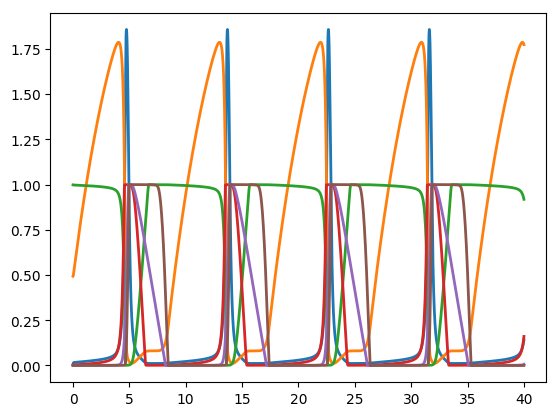

6-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7efe8b755d50>
 PyObject <matplotlib.lines.Line2D object at 0x7efe8b755f50>
 PyObject <matplotlib.lines.Line2D object at 0x7efe8b7640d0>
 PyObject <matplotlib.lines.Line2D object at 0x7efe8b764210>
 PyObject <matplotlib.lines.Line2D object at 0x7efe8b764350>
 PyObject <matplotlib.lines.Line2D object at 0x7efe8b764490>

In [25]:
plot(sol.t, sol.u, lw=2)

**Find limit cycle of previous oscillations**

In [26]:
u0 = [0.006,      # MPF
      0.493,      # MPF_P
      0.998,      # Wee1
      0.002,      # Cdc25_P
      0.000,      # IE_A
      0.000]      # APC_A
tspan = (0.0, 15.0)
dtmax = 0.001
sol = find_limit_cycle(f, u0, tspan, params; (:dtmax, dtmax))
cycle = sol
sol.errors

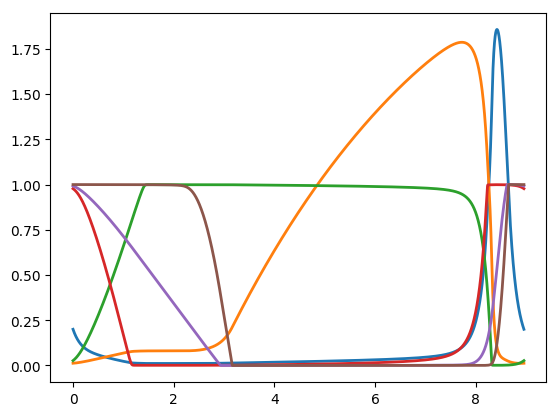

6-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7efe90147410>
 PyObject <matplotlib.lines.Line2D object at 0x7efe90147610>
 PyObject <matplotlib.lines.Line2D object at 0x7efe90147750>
 PyObject <matplotlib.lines.Line2D object at 0x7efe90147890>
 PyObject <matplotlib.lines.Line2D object at 0x7efe901479d0>
 PyObject <matplotlib.lines.Line2D object at 0x7efe90147b10>

In [27]:
plot(sol.t, sol.u, lw=2)

### Bifurcation plot

Function to follow limit cycles (AUTO not supported yet), using custom function

**Following steady state with variable Mass**

In [42]:
params = @NT(k_m0=0.4, k_m1=0.4, k_m1a=20.0, k_m2=0.4, k_m2a=50.0, k_m3=0.2, k_m3a=6.35, 
    V_w1=1.0, k_w2=5.3, J_w1=0.01, J_w2=0.01, k_c1=8.5, V_c2=1.4, k_c2a=2.2, J_c1=0.01, J_c2=0.01, 
    k_i1=1.7, V_i2=0.4, J_i1=0.001, J_i2=0.001, k_a1=6.8, V_a2=1.7, J_a1=0.001, J_a2=0.001, 
    alpha=0.05, Wee1_T=1.0, Cdc25_T=1.0, IE_T=1.0, APC_T=1.0, Chk2_T=1.0, theta_M=0.2, Mass=0.5)

(k_m0 = 0.4, k_m1 = 0.4, k_m1a = 20.0, k_m2 = 0.4, k_m2a = 50.0, k_m3 = 0.2, k_m3a = 6.35, V_w1 = 1.0, k_w2 = 5.3, J_w1 = 0.01, J_w2 = 0.01, k_c1 = 8.5, V_c2 = 1.4, k_c2a = 2.2, J_c1 = 0.01, J_c2 = 0.01, k_i1 = 1.7, V_i2 = 0.4, J_i1 = 0.001, J_i2 = 0.001, k_a1 = 6.8, V_a2 = 1.7, J_a1 = 0.001, J_a2 = 0.001, alpha = 0.05, Wee1_T = 1.0, Cdc25_T = 1.0, IE_T = 1.0, APC_T = 1.0, Chk2_T = 1.0, theta_M = 0.2, Mass = 0.5)

In [43]:
u0 = [0.00633974,
      0.493818,
      0.998055,
      0.00229303,
      0.00015174,
      6.06721e-7]
tspan = [0, 40]
dsargs = build_ode(f, u0, tspan, params)
dsargs[:pdomain] = Dict("Mass"=>[0.01, 4], "V_c2"=>[0.0, 6])
ode = ds[:Generator][:Vode_ODEsystem](dsargs)
ode[:set](pars = Dict("Mass"=>0.5))
PC = ds[:ContClass](ode)

PyObject ContClass of model CCMMV001

In [44]:
name1 = "EQ1"
PCargs = ds[:args](name=name1)
PCargs[:type] = "EP-C"
PCargs[:freepars] = ["Mass"]
PCargs[:MaxNumPoints] = 300
PCargs[:MaxStepSize] = 5e-2
PCargs[:MinStepSize] = 1e-5
PCargs[:MaxTestIters] = 20
PCargs[:LocBifPoints] = "all"
PCargs[:SaveEigen] = true
PCargs[:StopAtPoints] = ["B"]
PCargs[:verbosity] = 2
PC[:newCurve](PCargs)

In [45]:
# Commented to save computation, load "CCCMV001_data.jld"
PC[:curves][name1][:backward]()
PC[:curves][name1][:forward]()
PC[:curves][name1][:info]()

B Point found 
0 : 
MPF  =  0.000235883405411
Cdc25_P  =  7.41292144506e-05
IE_A  =  5.224329075e-06
APC_A  =  2.08768756945e-08
Mass  =  0.0099999954886
MPF_P  =  0.019764094315
Wee1  =  0.999935350442

Test function going crazy:  class Hopf_Bor(BorderMethod, BiAltMethod) 

Neutral saddle found!


Checking...
  |q| = 1.000000
  <p,q> = 1.000000
  |Aq| = 0.000040
  |transpose(A)p| = 0.000244

LP Point found 
0 : 
MPF  =  0.0486112091202
Cdc25_P  =  0.0405043328675
IE_A  =  0.00130777171391
APC_A  =  5.25331405607e-06
Mass  =  0.873042636851
MPF_P  =  1.69718287883
Wee1  =  0.9766418517

Eigenvalues = 

     (-1682.280176,0.000000)
     (-75.106076,0.000000)
     (-56.244476,0.000000)
     (0.000040,0.000000)
     (-0.198251,0.000000)
     (-8.894330,0.000000)


a = 68.047154932186018

Neutral saddle found!

Neutral saddle found!


Checking...
  |q| = 1.000000
  <p,q> = 1.000000
  |Aq| = 0.000001
  |transpose(A)p| = 0.000032

LP Point found 
0 : 
MPF  =  0.212896342895
Cdc25_P  =  0.968

In [46]:
curve_stst = bifurcation_curve_ccc(PC, "EQ1");

** Follow limit cycle**

In [20]:
# Commented to save computation, use load "CCCMV001_data.jld"
#dtmax = 0.001
#curve_lcycle = follow_limit_cycle(cycle, [1.747, 4.0], 0.01; (:dtmax, dtmax))

BifurcationCurve{DataStructures.OrderedDict{Symbol,Any},Dict{String,Any}}(DataStructures.OrderedDict{Symbol,Any}(:MPF=>Dict(:max=>[1.60713, 1.61248, 1.61697, 1.62104, 1.62482, 1.6284, 1.63183, 1.63512, 1.6383, 1.64139  …  1.97266, 1.97382, 1.97498, 1.97614, 1.97729, 1.97845, 1.9796, 1.98075, 1.98189, 1.98304],:min=>[0.0064886, 0.00652575, 0.0065629, 0.00660005, 0.0066372, 0.00667435, 0.00671151, 0.00674866, 0.00678582, 0.00682297  …  0.0145347, 0.0145721, 0.0146094, 0.0146468, 0.0146842, 0.0147215, 0.0147589, 0.0147963, 0.0148336, 0.014871]),:Mass=>[1.75, 1.76, 1.77, 1.78, 1.79, 1.8, 1.81, 1.82, 1.83, 1.84  …  3.91, 3.92, 3.93, 3.94, 3.95, 3.96, 3.97, 3.98, 3.99, 4.0]), String["LC", "LC", "LC", "LC", "LC", "LC", "LC", "LC", "LC", "LC"  …  "LC", "LC", "LC", "LC", "LC", "LC", "LC", "LC", "LC", "LC"], Dict{String,Any}(), Int64[])

In [47]:
PlotBifurcation(curve_stst, (:Mass, :MPF))
PlotBifurcation(curve_lcycle, (:Mass, :MPF))
xlim([0, 4])
xlabel(L"Mass")
ylabel("MPF")
yscale("log")
ylim([0.0001, 10])
title("Bifurcation diagram for cell mass")

LoadError: [91mBoundsError: attempt to access 189-element Array{String,1} at index [190][39m

In [19]:
#= Doesn't work: AUTO not supported
name2 = "HP3"
PCargs = ds[:args](name=name2)
PCargs[:type] = "LC-C"
PCargs[:initpoint] = "EQ1:H1"
PCargs[:freepars] = ["Mass"]
PCargs[:StepSize] = 1e-1
PCargs[:MaxNumPoints] = 10
PCargs[:MaxStepSize] = 1e-0
PCargs[:MinStepSize] = 1e-4
PCargs[:verbosity] = 2
PCargs[:SaveEigen] = true
PC[:newCurve](PCargs)
PC[:curves][name2][:forward]()
PC[:info]()
=#

**Two parameter bifurcation**: Mass and $V_{c2}$

Three fold points: first limit point (SNIC), second limit point (saddle-node), and Hopf point

In [48]:
namefold1="FO1"
PCargs = ds[:args](name=namefold1)
PCargs[:type] = "LP-C"
PCargs[:initpoint] = "EQ1:LP1"
PCargs[:freepars] = ["Mass", "V_c2"]
PCargs[:StepSize] = 1e-1
PCargs[:MaxNumPoints] = 100
PCargs[:MaxStepSize] = 1e-0
PCargs[:MinStepSize] = 1e-4
PCargs[:SaveEigen] = true
PCargs[:SaveJacobian] = true
PCargs[:LocBifPoints] = ["B"]
PCargs[:StopAtPoints] = ["B"]
PCargs[:verbosity] = 2
PC[:newCurve](PCargs)

In [49]:
PC[:curves][namefold1][:forward]()
PC[:curves][namefold1][:backward]()
PC[:curves][namefold1][:info]()

B Point found 
0 : 
MPF  =  0.0445035502025
Cdc25_P  =  0.00340946170463
IE_A  =  0.00334132028883
APC_A  =  1.35326155685e-05
Mass  =  1.39058423247
MPF_P  =  2.73547046959
Wee1  =  0.813528608116
V_c2  =  6.00000000771

B Point found 
0 : 
MPF  =  0.000552350188687
Cdc25_P  =  0.041567083247
IE_A  =  6.51581938146e-06
APC_A  =  2.60379182404e-08
Mass  =  0.0100000038367
MPF_P  =  0.0194476409505
Wee1  =  0.999919344029
V_c2  =  0.0159121074403

PyCont curve FO1 (type LP-C)
Using model: CCMMV001

Model Info
---------- 

  Variables : APC_A, Cdc25_P, IE_A, MPF, MPF_P, Wee1
  Parameters: APC_T, k_a1, V_i2, k_m1, k_m0, k_m3, k_m2, V_a2, k_c1, Cdc25_T, k_m3a, J_w1, J_w2, k_i1, k_w2, J_i1, J_i2, theta_M, J_a2, J_a1, Mass, V_w1, J_c2, k_m1a, alpha, V_c2, IE_T, k_m2a, k_c2a, Chk2_T, Wee1_T, J_c1

Continuation Parameters
----------------------- 

name  =  FO1
auxpars  =  []
freepars  =  ['Mass', 'V_c2']
MaxNumPoints  =  100
MaxCorrIters  =  5
MaxTestIters  =  10
MaxStepSize  =  1.0
MinStepSiz

In [50]:
curve_fold1 = bifurcation_curve_ccc(PC, "FO1");

In [26]:
namefold2 = "FO2"
PCargs = ds[:args](name=namefold2)
PCargs[:type] = "LP-C"
PCargs[:initpoint] = "EQ1:LP2"
PCargs[:freepars] = ["Mass", "V_c2"]
PCargs[:StepSize] = 1e-1
PCargs[:MaxNumPoints] = 100
PCargs[:MaxStepSize] = 1e-0
PCargs[:MinStepSize] = 1e-6
PCargs[:SaveEigen] = true
PCargs[:verbosity] = 2
PCargs[:LocBifPoints] = ["B"]
PCargs[:StopAtPoints] = ["B"]
PC[:newCurve](PCargs)

In [27]:
# Commented to save computation, use load "CCCMV001_data.jld"
#PC[:curves][namefold2][:forward]()
#PC[:curves][namefold2][:backward]()
#PC[:curves][namefold2][:info]()

B Point found 
0 : 
MPF  =  0.212201785909
Cdc25_P  =  0.999999999978
IE_A  =  0.0100192191603
APC_A  =  4.17066401331e-05
Mass  =  0.251641999497
MPF_P  =  0.0391074334822
Wee1  =  0.0679299440735
V_c2  =  4.04662940561e-09

PyCont curve FO2 (type LP-C)
Using model: CCMMV001

Model Info
---------- 

  Variables : APC_A, Cdc25_P, IE_A, MPF, MPF_P, Wee1
  Parameters: APC_T, k_a1, V_i2, k_m1, k_m0, k_m3, k_m2, V_a2, k_c1, Cdc25_T, k_m3a, J_w1, J_w2, k_i1, k_w2, J_i1, J_i2, theta_M, J_a2, J_a1, Mass, V_w1, J_c2, k_m1a, alpha, V_c2, IE_T, k_m2a, k_c2a, Chk2_T, Wee1_T, J_c1

Continuation Parameters
----------------------- 

name  =  FO2
auxpars  =  []
freepars  =  ['Mass', 'V_c2']
MaxNumPoints  =  100
MaxCorrIters  =  5
MaxTestIters  =  10
MaxStepSize  =  1.0
MinStepSize  =  1e-06
StepSize  =  0.295252197362
VarTol  =  1e-06
FuncTol  =  1e-06
TestTol  =  0.0001
LocBifPoints  =  ['B']
verbosity  =  2
ClosedCurve  =  50
SaveJacobian  =  False
SaveEigen  =  True
Corrector  =  <bound method Fol

In [28]:
curve_fold2 = bifurcation_curve_ccc(PC, "FO2");

In [24]:
#= Doesn't work: tangent vector problem
namefold3="FO3"
PCargs = ds[:args](name=namefold3)
PCargs[:type] = "LP-C"
PCargs[:initpoint] = "EQ1:H1"
PCargs[:freepars] = ["Mass", "V_c2"]
PCargs[:StepSize] = 1e-1
PCargs[:MaxNumPoints] = 12
PCargs[:MaxStepSize] = 1e-0
PCargs[:MinStepSize] = 1e-4
PCargs[:SaveEigen] = true
PCargs[:SaveJacobian] = true
PCargs[:verbosity] = 2
PCargs[:StopAtPoints] = ["B"]
PC[:newCurve](PCargs)
PC[:curves][namefold3][:forward]()
PC[:curves][namefold3][:info]()
=#

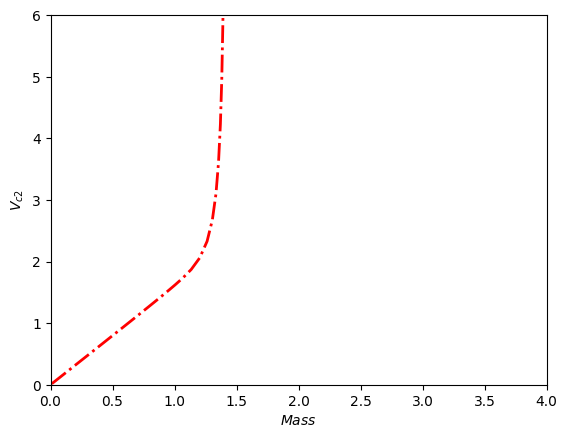

In [51]:
PlotBifurcation(curve_fold1, (:Mass, :V_c2))
#PlotBifurcation(curve_fold2, (:Mass, :V_c2))
xlim([0, 4])
xlabel(L"Mass")
ylim([0, 6])
ylabel(L"V_{c2}")
title("")
show()

All curves together

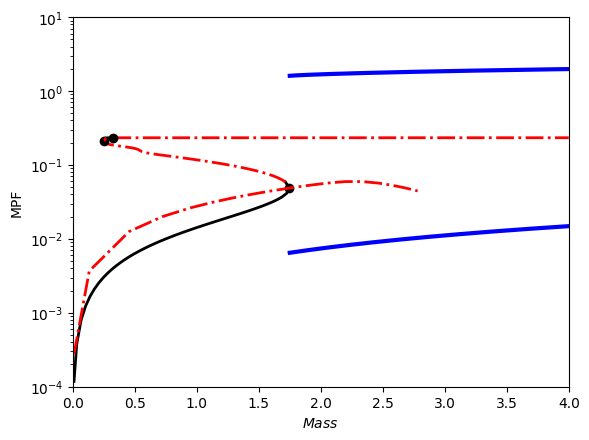

In [31]:
PlotBifurcation(curve_stst, (:Mass, :MPF))
PlotBifurcation(curve_lcycle, (:Mass, :MPF))
PlotBifurcation(curve_fold1, (:Mass, :MPF))
PlotBifurcation(curve_fold2, (:Mass, :MPF))
xlim([0, 4])
xlabel(L"Mass")
ylabel("MPF")
yscale("log")
ylim([0.0001, 10])
show()

## High value of $V_{c2}=3.6$
Now, we change the value of $V_{c2}$ to $V_{c2}+k_{c2a}=3.6$ and reproduce the bifurcation biagram again

### Some solutions

**Interphase**

In [91]:
params = @NT(k_m0=0.2, k_m1=0.4, k_m1a=20.0, k_m2=0.4, k_m2a=50.0, k_m3=0.2, k_m3a=6.35, 
    V_w1=1.0, k_w2=5.3, J_w1=0.01, J_w2=0.01, k_c1=8.5, V_c2=3.6, k_c2a=2.2, J_c1=0.01, J_c2=0.01, 
    k_i1=1.7, V_i2=0.4, J_i1=0.001, J_i2=0.001, k_a1=6.8, V_a2=1.7, J_a1=0.001, J_a2=0.001, 
    alpha=0.05, Wee1_T=1.0, Cdc25_T=1.0, IE_T=1.0, APC_T=1.0, Chk2_T=1.0, theta_M=0.2, Mass=0.5)

(k_m0 = 0.2, k_m1 = 0.4, k_m1a = 20.0, k_m2 = 0.4, k_m2a = 50.0, k_m3 = 0.2, k_m3a = 6.35, V_w1 = 1.0, k_w2 = 5.3, J_w1 = 0.01, J_w2 = 0.01, k_c1 = 8.5, V_c2 = 3.7, k_c2a = 2.2, J_c1 = 0.01, J_c2 = 0.01, k_i1 = 1.7, V_i2 = 0.4, J_i1 = 0.001, J_i2 = 0.001, k_a1 = 6.8, V_a2 = 1.7, J_a1 = 0.001, J_a2 = 0.001, alpha = 0.05, Wee1_T = 1.0, Cdc25_T = 1.0, IE_T = 1.0, APC_T = 1.0, Chk2_T = 1.0, theta_M = 0.2, Mass = 0.5)

In [92]:
u0 = [0.006,      # MPF
      0.493,      # MPF_P
      0.998,      # Wee1
      0.000,      # Cdc25_P
      0.000,      # IE_A
      0.000]      # APC_A
tspan = (0.0, 40.0)
dtmax = 0.1
alg = Rosenbrock23()
prob = ODEProblem(f, u0, tspan, params)
sol = solve(prob, alg; (:dtmax, dtmax))
sol.errors

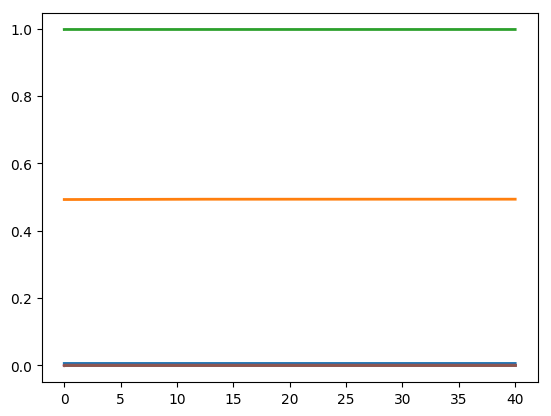

6-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fefedc65d90>
 PyObject <matplotlib.lines.Line2D object at 0x7fefedc65f90>
 PyObject <matplotlib.lines.Line2D object at 0x7fefedc71110>
 PyObject <matplotlib.lines.Line2D object at 0x7fefedc71250>
 PyObject <matplotlib.lines.Line2D object at 0x7fefedc71390>
 PyObject <matplotlib.lines.Line2D object at 0x7fefedc714d0>

In [93]:
plot(sol.t, sol.u, lw=2)

**M-phase**

In [94]:
params = @NT(k_m0=0.2, k_m1=0.4, k_m1a=20.0, k_m2=0.4, k_m2a=50.0, k_m3=0.2, k_m3a=6.35, 
    V_w1=1.0, k_w2=5.3, J_w1=0.01, J_w2=0.01, k_c1=8.5, V_c2=3.6, k_c2a=2.2, J_c1=0.01, J_c2=0.01, 
    k_i1=1.7, V_i2=0.4, J_i1=0.001, J_i2=0.001, k_a1=6.8, V_a2=1.7, J_a1=0.001, J_a2=0.001, 
    alpha=0.05, Wee1_T=1.0, Cdc25_T=1.0, IE_T=1.0, APC_T=1.0, Chk2_T=1.0, theta_M=0.2, Mass=3.0)

(k_m0 = 0.2, k_m1 = 0.4, k_m1a = 20.0, k_m2 = 0.4, k_m2a = 50.0, k_m3 = 0.2, k_m3a = 6.35, V_w1 = 1.0, k_w2 = 5.3, J_w1 = 0.01, J_w2 = 0.01, k_c1 = 8.5, V_c2 = 3.7, k_c2a = 2.2, J_c1 = 0.01, J_c2 = 0.01, k_i1 = 1.7, V_i2 = 0.4, J_i1 = 0.001, J_i2 = 0.001, k_a1 = 6.8, V_a2 = 1.7, J_a1 = 0.001, J_a2 = 0.001, alpha = 0.05, Wee1_T = 1.0, Cdc25_T = 1.0, IE_T = 1.0, APC_T = 1.0, Chk2_T = 1.0, theta_M = 0.2, Mass = 3.0)

In [95]:
u0 = [0.016,      # MPF
      0.602,      # MPF_P
      0.994,      # Wee1
      0.001,      # Cdc25_P
      0.000,      # IE_A
      0.000]      # APC_A
tspan=(0.0, 25.0)
prob = ODEProblem(f, u0, tspan, params)
dtmax = 0.001
sol = solve(prob, alg; (:dtmax, dtmax))
sol.errors

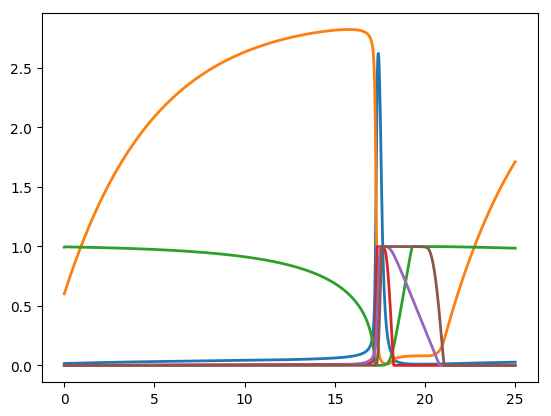

6-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fefecf20250>
 PyObject <matplotlib.lines.Line2D object at 0x7fefecf20450>
 PyObject <matplotlib.lines.Line2D object at 0x7fefecf20590>
 PyObject <matplotlib.lines.Line2D object at 0x7fefecf206d0>
 PyObject <matplotlib.lines.Line2D object at 0x7fefecf20810>
 PyObject <matplotlib.lines.Line2D object at 0x7fefecf20950>

In [96]:
plot(sol.t, sol.u, lw=2)

**Find limit cycle**

In [97]:
u0 = [0.016,      # MPF
      0.602,      # MPF_P
      0.994,      # Wee1
      0.001,      # Cdc25_P
      0.000,      # IE_A
      0.000]      # APC_A
tspan = (0.0, 25.0)
dtmax = 0.001
sol = find_limit_cycle(f, u0, tspan, params; (:dtmax, dtmax))
cycle2 = sol
sol.errors

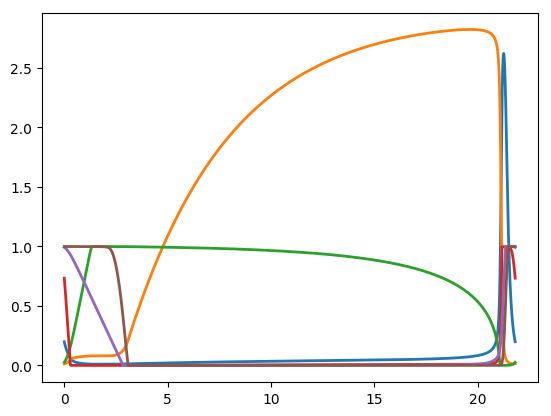

6-element Array{PyCall.PyObject,1}:
 PyObject <matplotlib.lines.Line2D object at 0x7fefed046090>
 PyObject <matplotlib.lines.Line2D object at 0x7fefed046290>
 PyObject <matplotlib.lines.Line2D object at 0x7fefed0463d0>
 PyObject <matplotlib.lines.Line2D object at 0x7fefed046510>
 PyObject <matplotlib.lines.Line2D object at 0x7fefed046650>
 PyObject <matplotlib.lines.Line2D object at 0x7fefed046790>

In [98]:
plot(sol.t, sol.u, lw=2)

### Bifurcation

**Follow steady state**

In [103]:
u0 = [0.00633974,
      0.493818,
      0.998055,
      0.00229303,
      0.00015174,
      6.06721e-7]
tspan = [0, 40]
dsargs = build_ode(f, u0, tspan, params)
dsargs[:pdomain] = Dict("Mass"=>[0.01, 4], "V_c2"=>[0.0, 6])
ode = ds[:Generator][:Vode_ODEsystem](dsargs)
ode[:set](pars = Dict("Mass"=>0.5, "V_c2"=>3.6))
PC = ds[:ContClass](ode)

PyObject ContClass of model CCMMV001

In [104]:
name1 = "EQ1"
PCargs = ds[:args](name=name1)
PCargs[:type] = "EP-C"
PCargs[:freepars] = ["Mass"]
PCargs[:MaxNumPoints] = 300
PCargs[:MaxStepSize] = 5e-2
PCargs[:MinStepSize] = 1e-5
PCargs[:MaxTestIters] = 20
PCargs[:LocBifPoints] = "all"
PCargs[:SaveEigen] = true
PCargs[:StopAtPoints] = ["B"]
PCargs[:verbosity] = 2
PC[:newCurve](PCargs)

In [105]:
# Commented to save computation, load "CCCMV001_data.jld"
PC[:curves][name1][:backward]()
PC[:curves][name1][:forward]()
PC[:curves][name1][:info]()

B Point found 
0 : 
MPF  =  0.000117704607485
Cdc25_P  =  1.39355214124e-05
IE_A  =  2.60439660466e-06
APC_A  =  1.04072875498e-08
Mass  =  0.00999998743515
MPF_P  =  0.00988227952335
Wee1  =  0.999967791271


Checking...
  |q| = 1.000000
  <p,q> = 1.000000
  |Aq| = 0.000000
  |transpose(A)p| = 0.000001

LP Point found 
0 : 
MPF  =  0.0474203588258
Cdc25_P  =  0.00697876457445
IE_A  =  0.00329721777477
APC_A  =  1.33516119984e-05
Mass  =  2.71456871159
MPF_P  =  2.66599809756
Wee1  =  0.823681750013

Eigenvalues = 

     (-1655.499394,0.000000)
     (-133.065572,0.000000)
     (0.000000,0.000000)
     (-0.199894,0.000000)
     (-21.661256,0.000000)
     (-37.923999,0.000000)


a = 1.8989897622917009

Neutral saddle found!

Test function going crazy:  class Hopf_Bor(BorderMethod, BiAltMethod) 


Checking...
  |q| = 1.000000
  <p,q> = 1.000000
  |Aq| = 0.000000
  |transpose(A)p| = 0.000000

LP Point found 
0 : 
MPF  =  0.203207670794
Cdc25_P  =  0.0112627785194
IE_A  =  0.0879822115616
A

In [106]:
curve_stst2 = bifurcation_curve_ccc(PC, "EQ1");

** Follow limit cycle**

In [110]:
# Commented to save computation, load "CCCMV001_data.jld"
#dtmax = 0.001
#curve_lcycle2 = follow_limit_cycle(cycle2, [2.72, 4.0], 0.01; (:dtmax, dtmax))

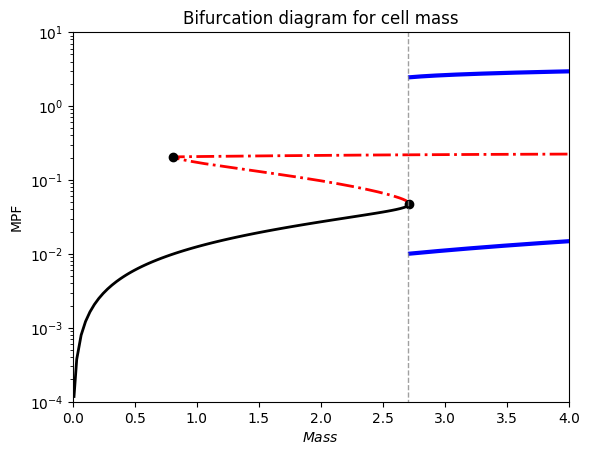

PyObject <matplotlib.text.Text object at 0x7fefed53ea90>

In [109]:
PlotBifurcation(curve_stst2, (:Mass, :MPF))
PlotBifurcation(curve_lcycle2, (:Mass, :MPF))
xlim([0, 4])
xlabel(L"Mass")
ylabel("MPF")
yscale("log")
ylim([0.0001, 10])
title("Bifurcation diagram for cell mass")

## Save results

In [90]:
@save "CCMMV001_data.jld" curve_stst curve_lcycle curve_fold1 curve_fold2 curve_stst2 curve_lcycle2